In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import utils_plots as ut

In [2]:
# Set directories
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
results_dir = os.path.join(fs_dir, 'results')
# Set basin array and basin names array
basin_names = ['North East Pacific', 'North West Pacific', 'North Atlantic', 'North Indian', 'South Indian', 'South Pacific']
basins = ['NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']
# Set neural network as final model for comparison
FINAL_MODEL = 'mlp'

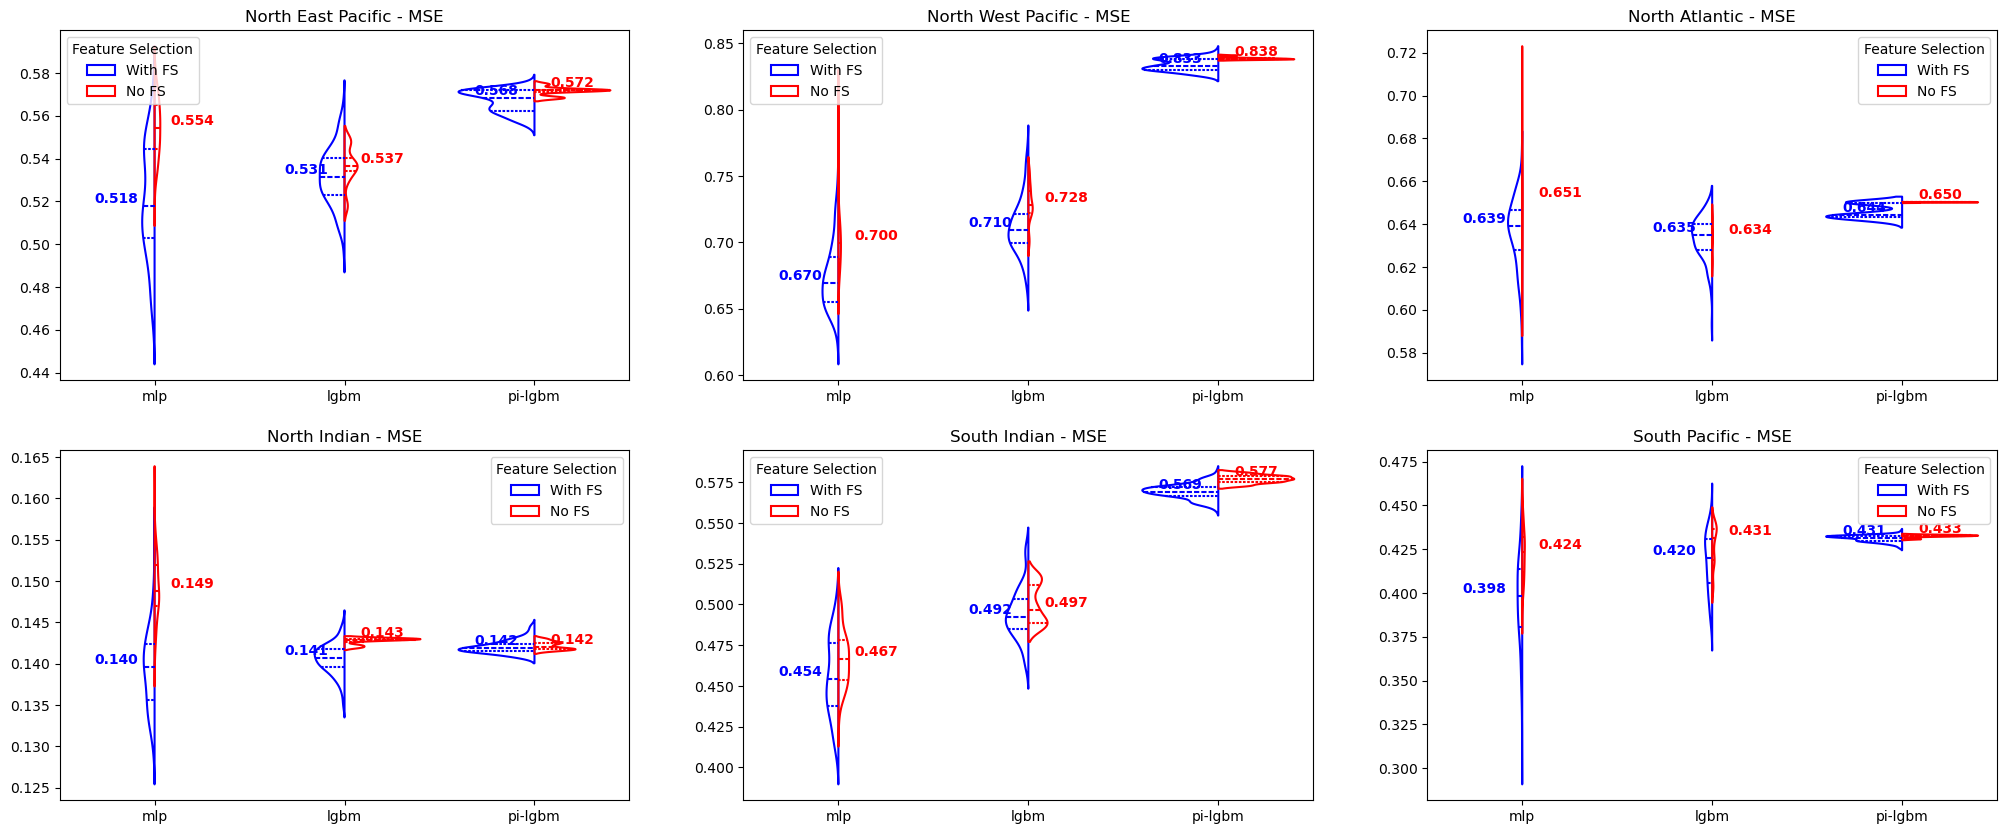

In [3]:
fmod_violin_fig = ut.final_models_violins('MSE', results_dir, basins, basin_names)
# fmod_violin_figY = ut.final_models_violins('MSE_Y', results_dir, basins, basin_names)

In [4]:
# fmod_violin_fig = ut.final_models_violins('R', results_dir, basins, basin_names)
# fmod_violin_figY = ut.final_models_violins('R_Y', results_dir, basins, basin_names)

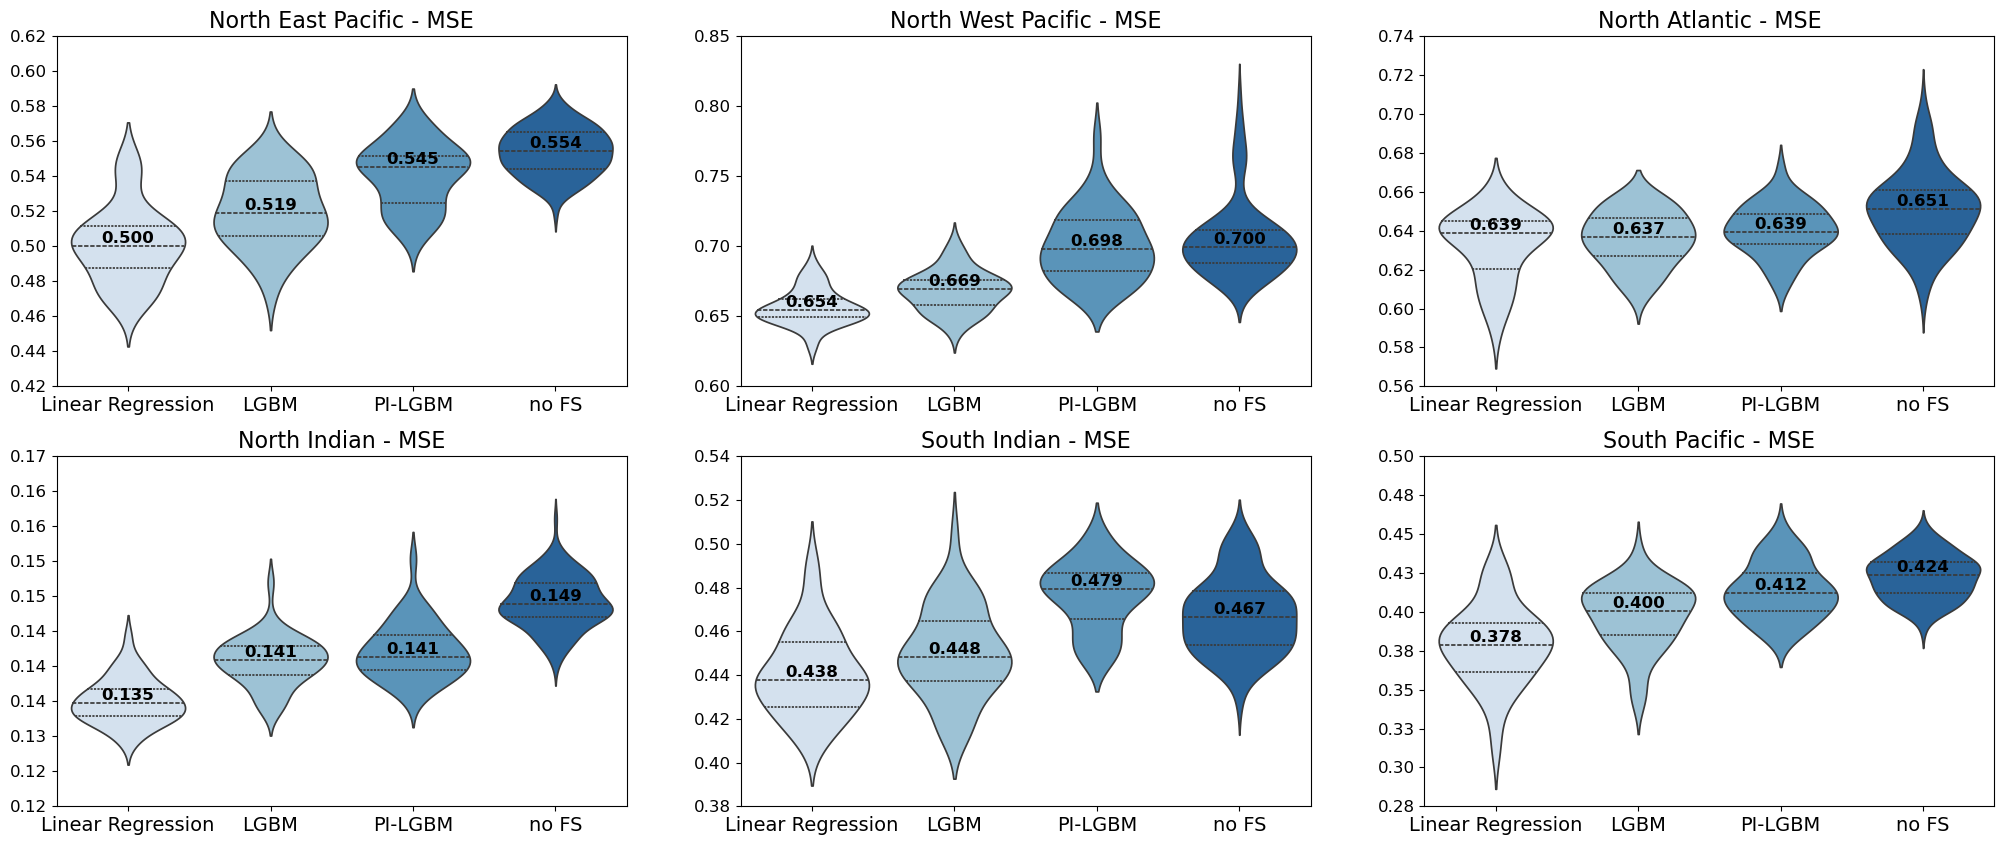

In [5]:
model_violin_fig = ut.fs_models_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names)

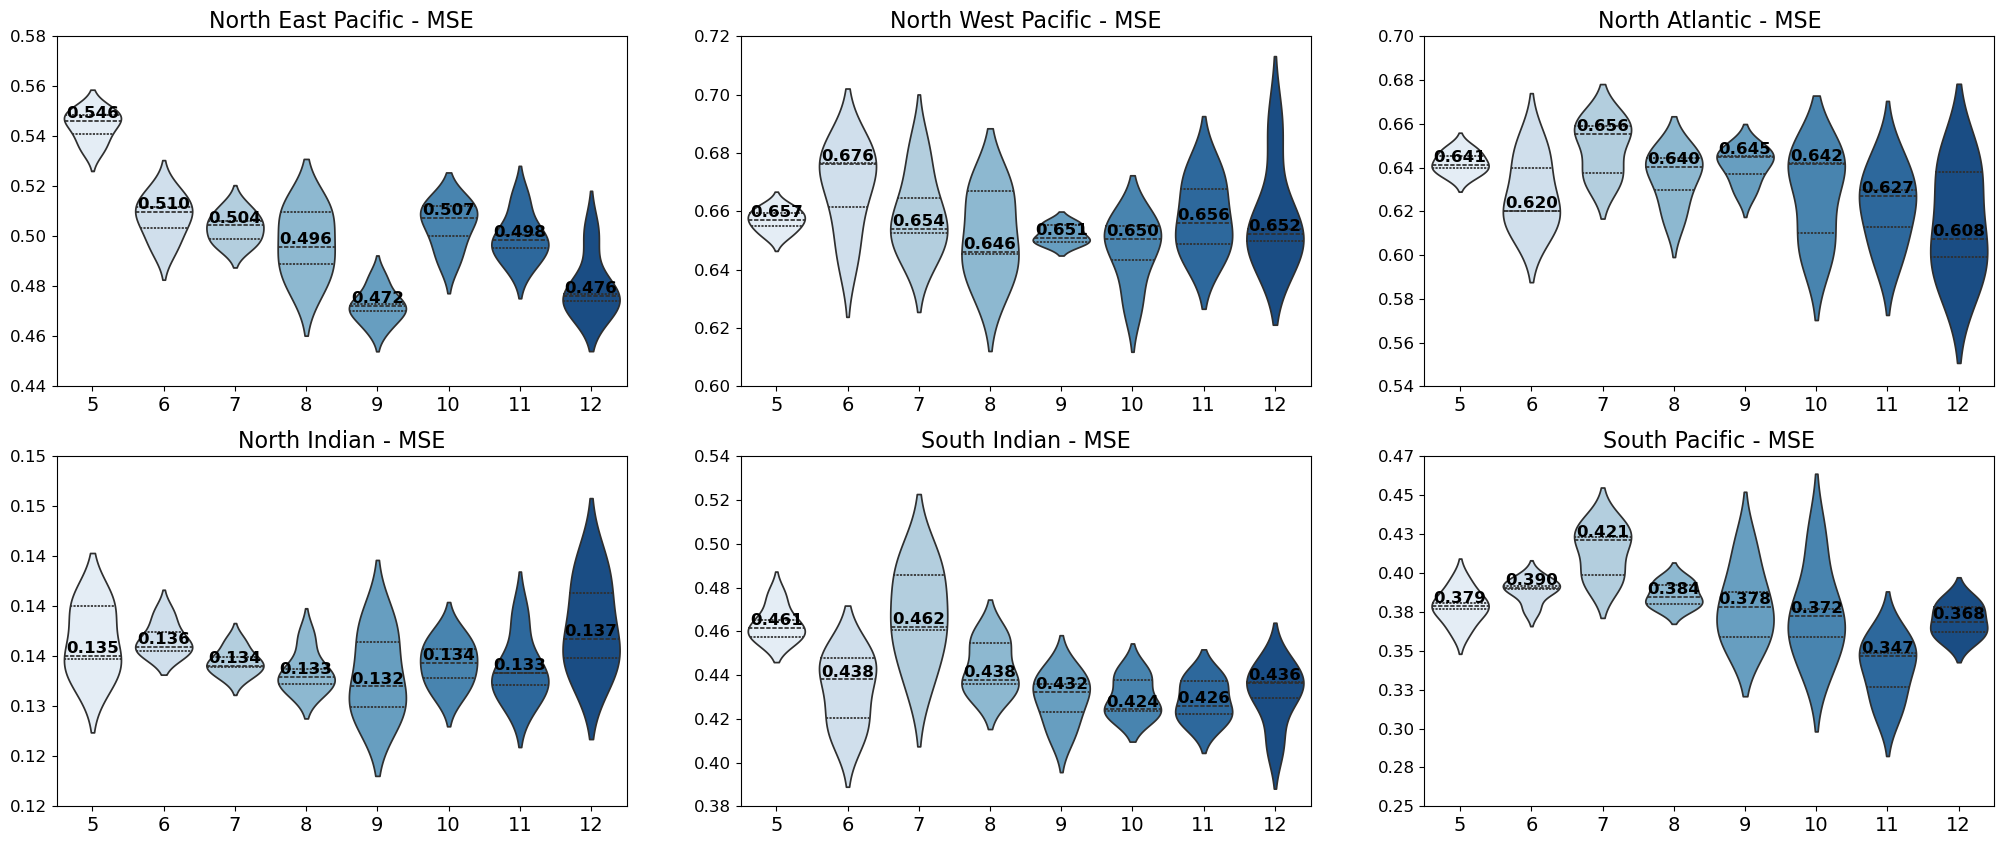

In [6]:
ncl_violin_fig = ut.n_clusters_violins('MSE', FINAL_MODEL, 'linreg', results_dir, basins, basin_names)

In [17]:
for bb, basin in enumerate(basins):
    # Load the performance file for the basin and filter to get the simulation with the best performance
    track_file = os.path.join(results_dir, f'sim_performance_{basin}_noTS.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    performance_cols = [f'MSE_{FINAL_MODEL}', f'R_{FINAL_MODEL}', f'R_Y_{FINAL_MODEL}']
    print(f'=============== {basin_names[bb]} ===============')
    for performance_col in performance_cols:
        # Get the simulation with the best performance
        metric = performance_col.split('_')[0]
        if metric == 'R':
            sorted_df = track_df.sort_values(performance_col, ascending=False)
        else:
            sorted_df = track_df.sort_values(performance_col, ascending=True)
        # print(f'{basin_names[bb]} - {n_clusters[bb]} clusters - {model_kinds[bb]} - {cluster_types[bb]}')
        # print(f'Best NN model for {basin} with FS: {best_sim.name} - mse: {best_sim[f"MSE_{FINAL_MODEL}"]:.3f}')
        corr_best_model = sorted_df.iloc[0][performance_col]
        corr_worst_model = sorted_df.iloc[-1][performance_col]
        print(f'{performance_col} - best model: {corr_best_model:.3f} - worst model: {corr_worst_model:.3f}')
        # Get the best annual correlation for a model with no features selection
        sorted_df_noFS = track_df.sort_values(f'MSE_{FINAL_MODEL}_noFS', ascending=True)
        best_sim_noFS = sorted_df_noFS.iloc[0]
        # print(f'Best NN model for {basin} no FS: {best_sim_noFS.name} - mse: {best_sim_noFS[f"MSE_{FINAL_MODEL}_noFS"]:.3f}')

=============== North East Pacific ===============
MSE_mlp - best model: 0.464 - worst model: 0.573
R_mlp - best model: 0.406 - worst model: -0.015
R_Y_mlp - best model: 0.738 - worst model: -0.092
=============== North West Pacific ===============
MSE_mlp - best model: 0.628 - worst model: 0.778
R_mlp - best model: 0.499 - worst model: 0.281
R_Y_mlp - best model: 0.510 - worst model: 0.140
=============== North Atlantic ===============
MSE_mlp - best model: 0.586 - worst model: 0.672
R_mlp - best model: 0.299 - worst model: -0.052
R_Y_mlp - best model: 0.600 - worst model: -0.122
=============== North Indian ===============
MSE_mlp - best model: 0.129 - worst model: 0.155
R_mlp - best model: 0.305 - worst model: 0.030
R_Y_mlp - best model: 0.400 - worst model: -0.118
=============== South Indian ===============
MSE_mlp - best model: 0.408 - worst model: 0.504
R_mlp - best model: 0.534 - worst model: 0.338
R_Y_mlp - best model: 0.539 - worst model: -0.078
=============== South Pacific 

In [10]:
n_clusters_list = [9, 8, 12, 9, 10, 11]

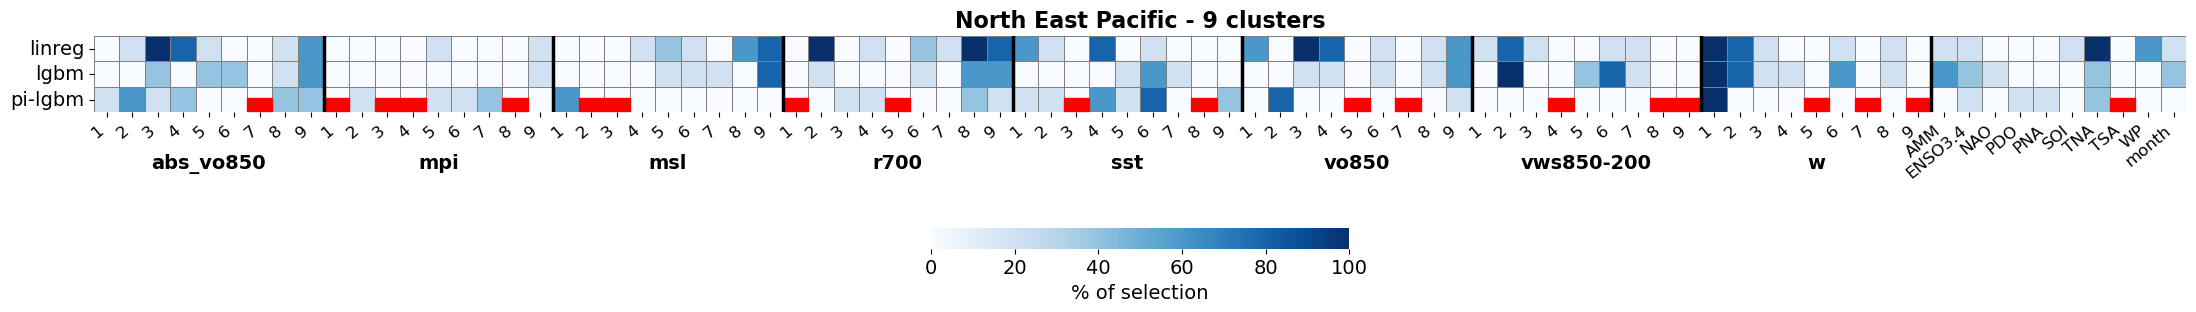

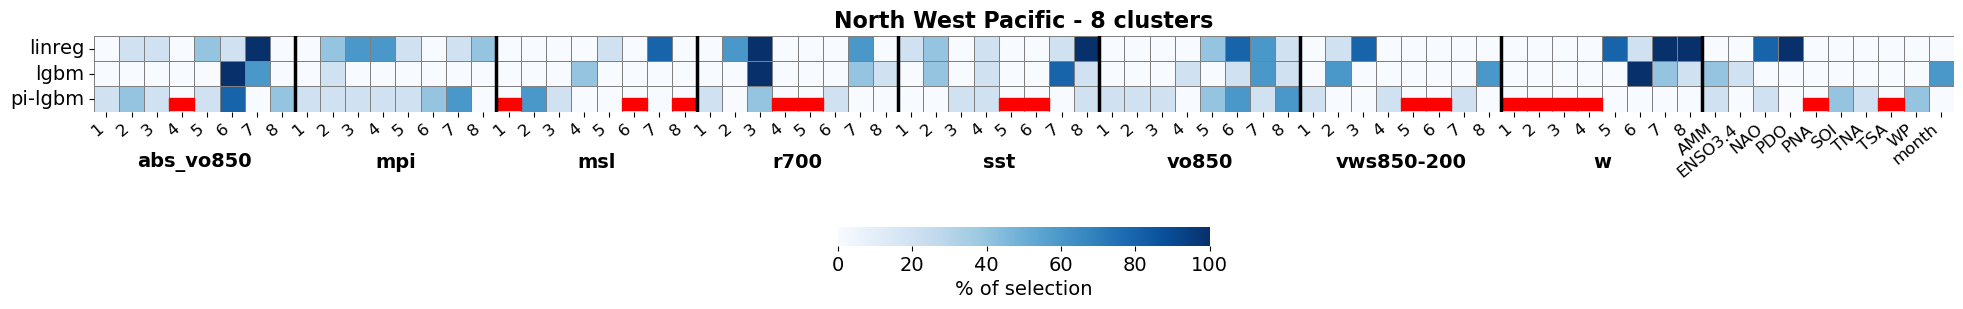

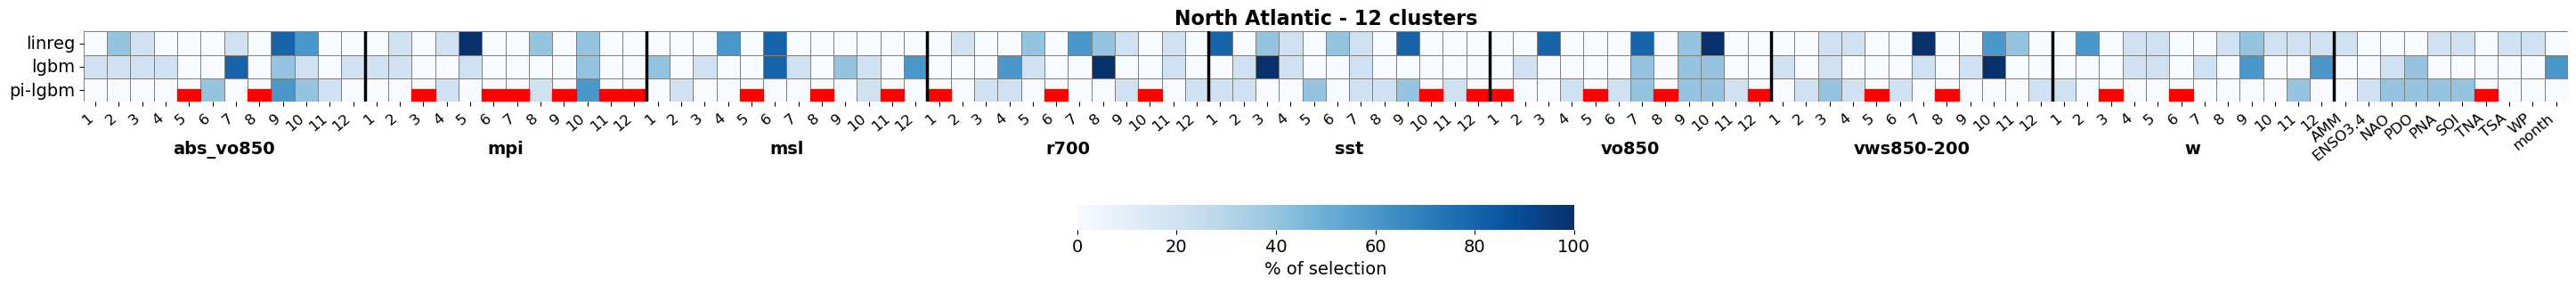

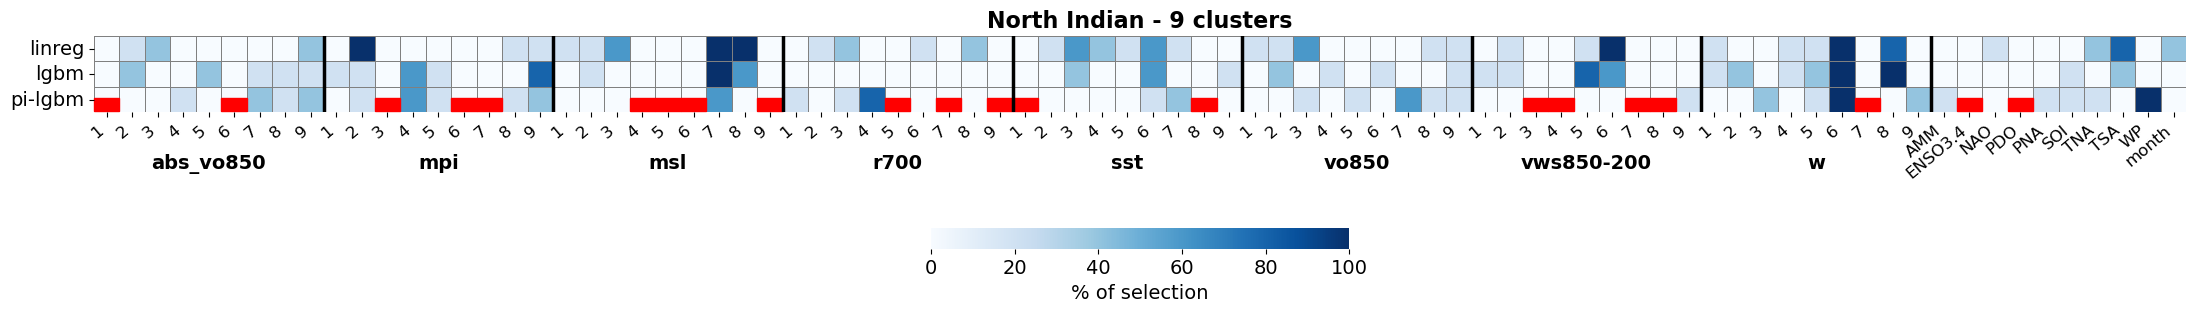

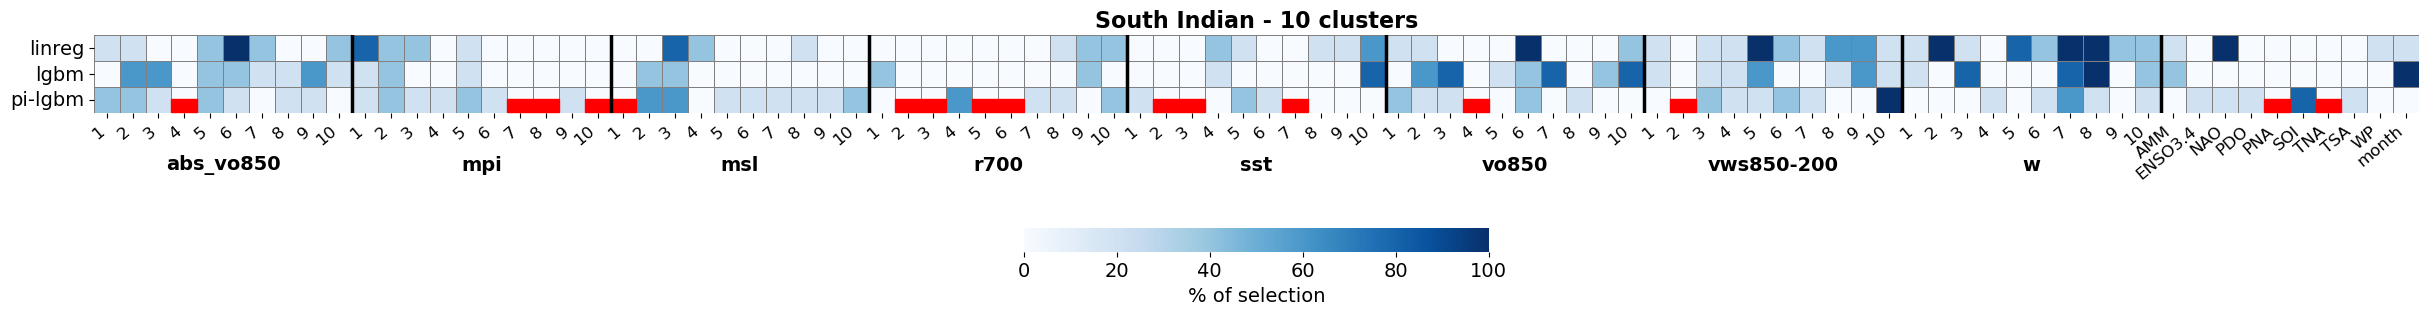

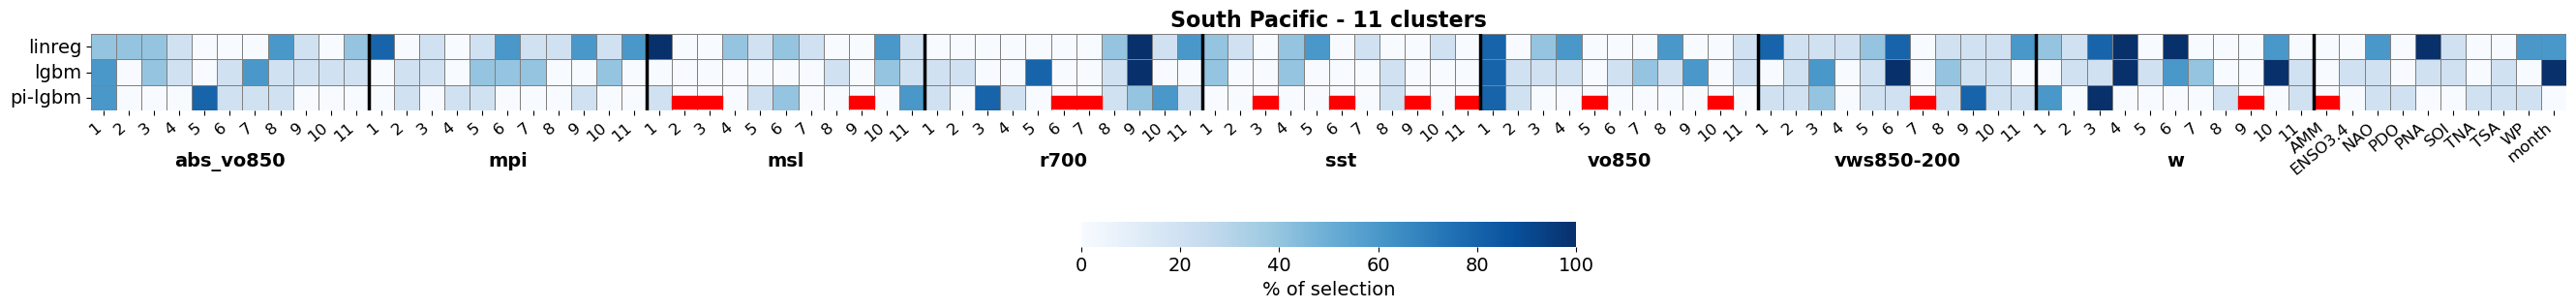

In [11]:
for bb, basin in enumerate(basins):
    # Set the number of clusters according ot the basin
    n_clusters = n_clusters_list[basins.index(basin)]
    # Get the predictors for the basin and the number of clusters
    cluster_data = f'{basin}_{n_clusters}clusters_noTS'
    experiment_filename = f'1980-2022_{n_clusters}clusters_8vars_9idxs.csv'
    predictor_file = 'predictors_' + experiment_filename
    predictors_path = os.path.join(fs_dir, 'data', cluster_data, predictor_file)
    predictors_df = pd.read_csv(predictors_path, index_col=0)
    predictors_df.index = pd.to_datetime(predictors_df.index)
    candidate_variables = predictors_df.columns.to_numpy()
    # Load the performance file for the basin and filter to get the simulation with the best performance
    track_file = os.path.join(results_dir, f'sim_performance_{basin}_noTS.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df['n_clusters'] == n_clusters]
    # Build the df containing the number of selection of each predictors
    df_tier_sel_perc_fsmodels = pd.DataFrame(0, columns=candidate_variables, index=['linreg', 'lgbm', 'pi-lgbm'])
    for r, run_name in enumerate(track_df.index):
        model_kind = run_name.split('_')[1]
        sol_filename = f'{model_kind}_{experiment_filename}'
        output_dir = os.path.join(fs_dir, 'results', basin, run_name)
        best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
        best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
        best_solution = best_solution.to_numpy().flatten()
        # get feature selection model from run name
        model_kind = track_df.loc[run_name, 'model']
        # Select the variables from the best solutions
        column_names = predictors_df.columns.tolist()
        feat_sel = best_solution[2*len(column_names):]
        df_tier_sel_perc_fsmodels.loc[model_kind] = df_tier_sel_perc_fsmodels.loc[model_kind] + feat_sel
    # Get the percentage of selection
    df_tier_sel_perc_fsmodels = (df_tier_sel_perc_fsmodels / 5) * 100
    # Set the figure for the heatmap percentage of selection
    plt.figure(figsize=(3*n_clusters, 10))
    ax = sns.heatmap(df_tier_sel_perc_fsmodels, cmap="Blues", linewidths=0.5, linecolor="gray", square=True,
                    cbar_kws={'orientation': 'horizontal', 'label': '% of selection', 'shrink': 0.2, 'aspect': 20})
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('% of selection', fontsize=14)
    # Set xticks labels
    features_clustered = [var for var in candidate_variables if 'cluster' in var]
    features_non_clustered = [var for var in candidate_variables if 'cluster' not in var]
    cluster_numbers = [col.split("cluster")[-1] if "cluster" in col else "" for col in features_clustered]
    variables = [col.split("_cluster")[0] for col in features_clustered]
    variable_positions = [variables.index(var) for var in sorted(set(variables), key=variables.index)]
    xticks_labels = cluster_numbers + features_non_clustered
    ax.set_xticks(np.arange(len(candidate_variables)) + 0.5)  
    ax.set_xticklabels(xticks_labels, rotation=40, ha="right", fontsize=12)
    for i, var in enumerate(sorted(set(variables), key=variables.index)):
        xpos = variable_positions[i] + (variable_positions[i+1] - variable_positions[i]) / 2 if i < len(variable_positions) - 1 else variable_positions[i] + n_clusters/2
        ax.text(xpos, len(df_tier_sel_perc_fsmodels) + 2, var, ha='center', va='center', fontsize=14, fontweight="bold")
    # Set the vertical lines between the different variables a bit thicker 
    thick_line_pos = [i+1 for i, var in enumerate(candidate_variables) if var.split('_cluster')[-1] == str(n_clusters)]
    for pos in thick_line_pos:
        ax.vlines(x=pos, ymin=-0.5, ymax=len(df_tier_sel_perc_fsmodels), linewidth=2.5, color="black")
    # Overlay red blocks at the bottom for zero columns
    zero_columns = (df_tier_sel_perc_fsmodels == 0).all(axis=0)
    for idx, is_zero in enumerate(zero_columns):
        if is_zero:
            ax.add_patch(plt.Rectangle((idx, len(df_tier_sel_perc_fsmodels) - 0.55), 1, 0.5, color='red', clip_on=False))
    # Set the yticks labels fontsize
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    # Set the title
    plt.title(f'{basin_names[bb]} - {n_clusters} clusters', fontsize=16, fontweight="bold")
    plt.show()

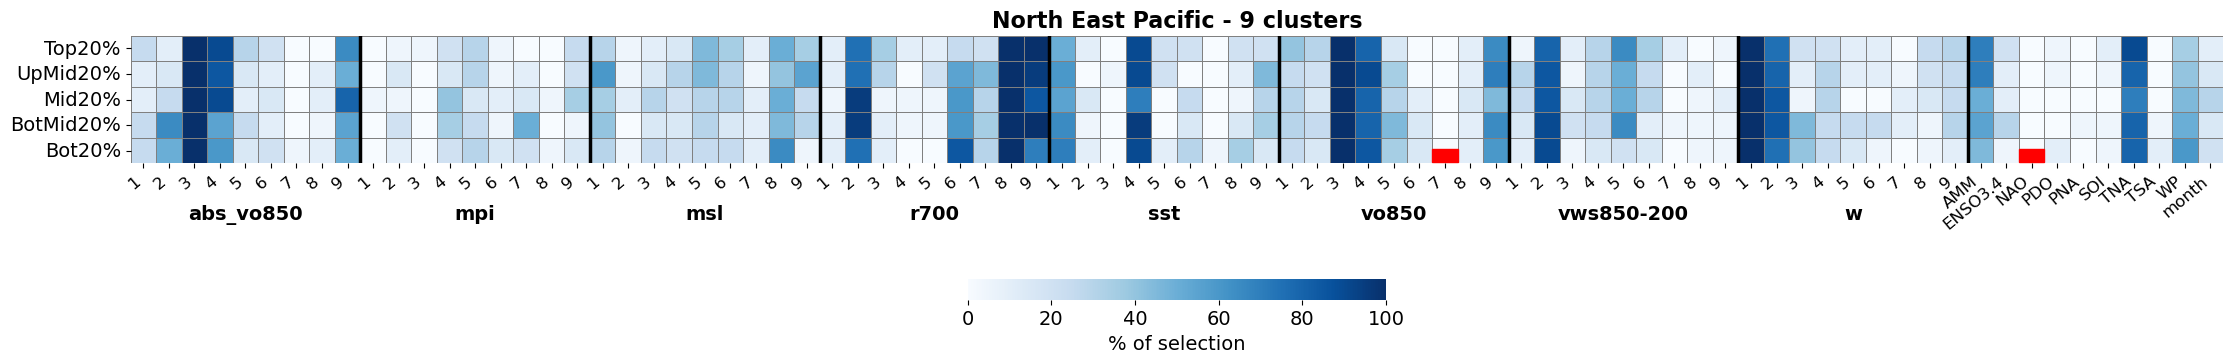

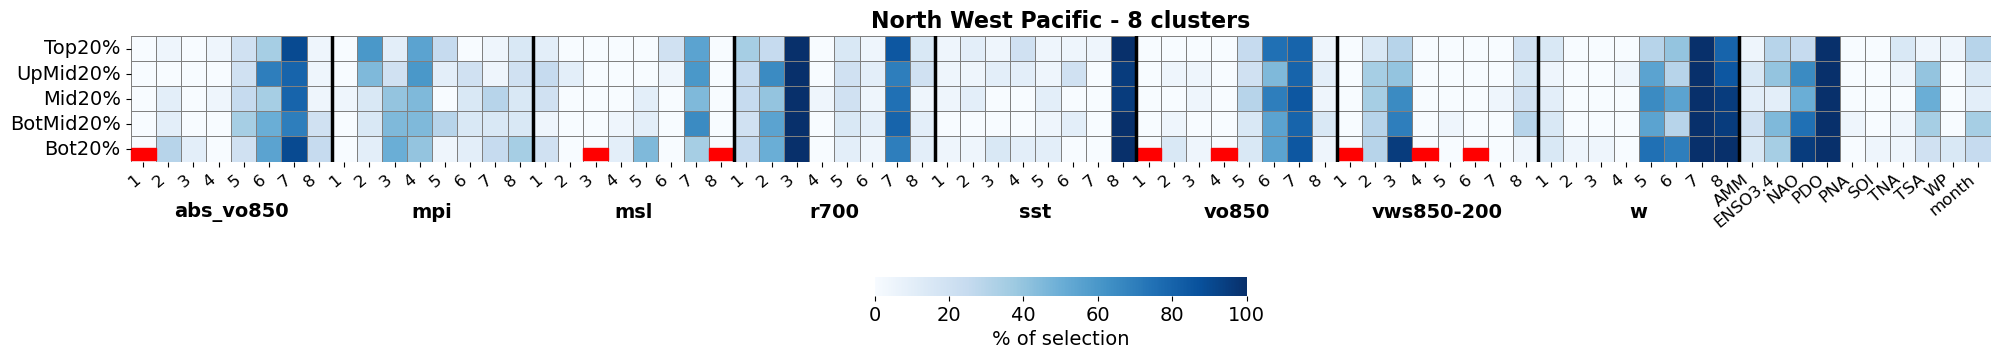

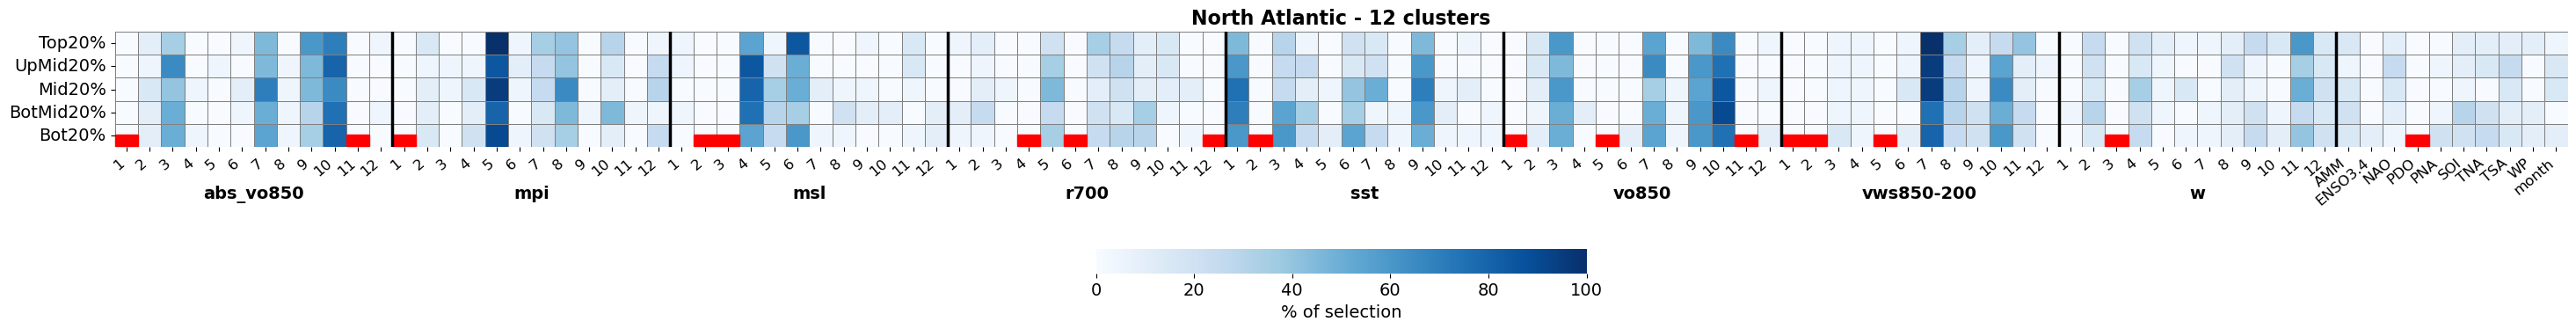

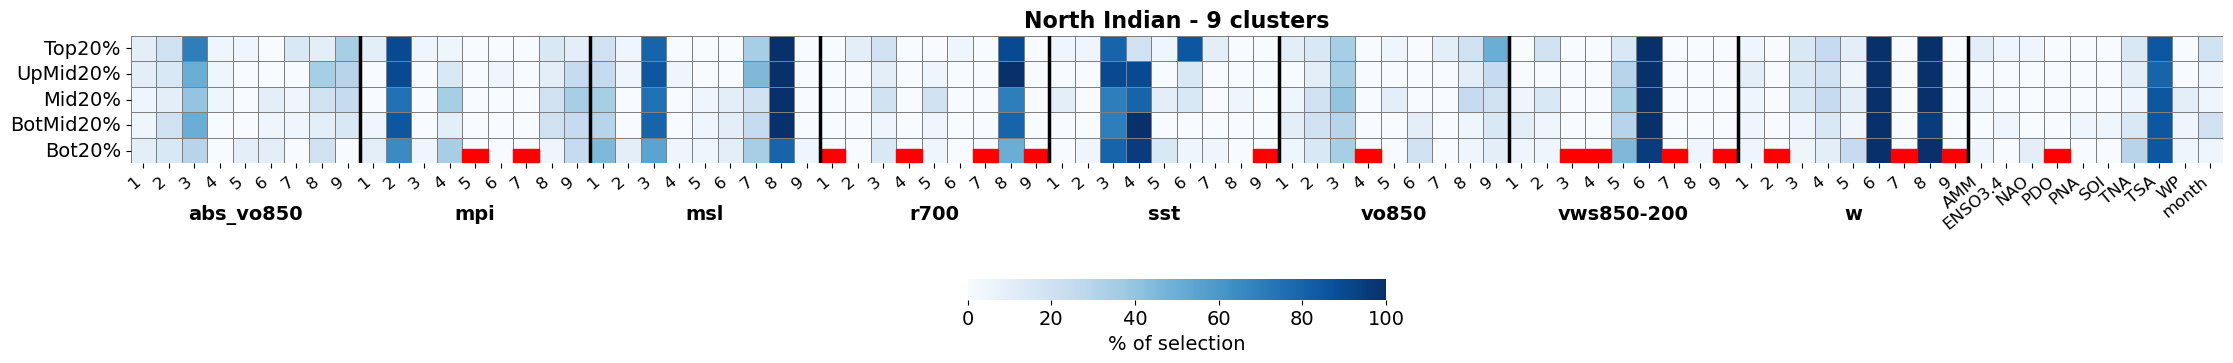

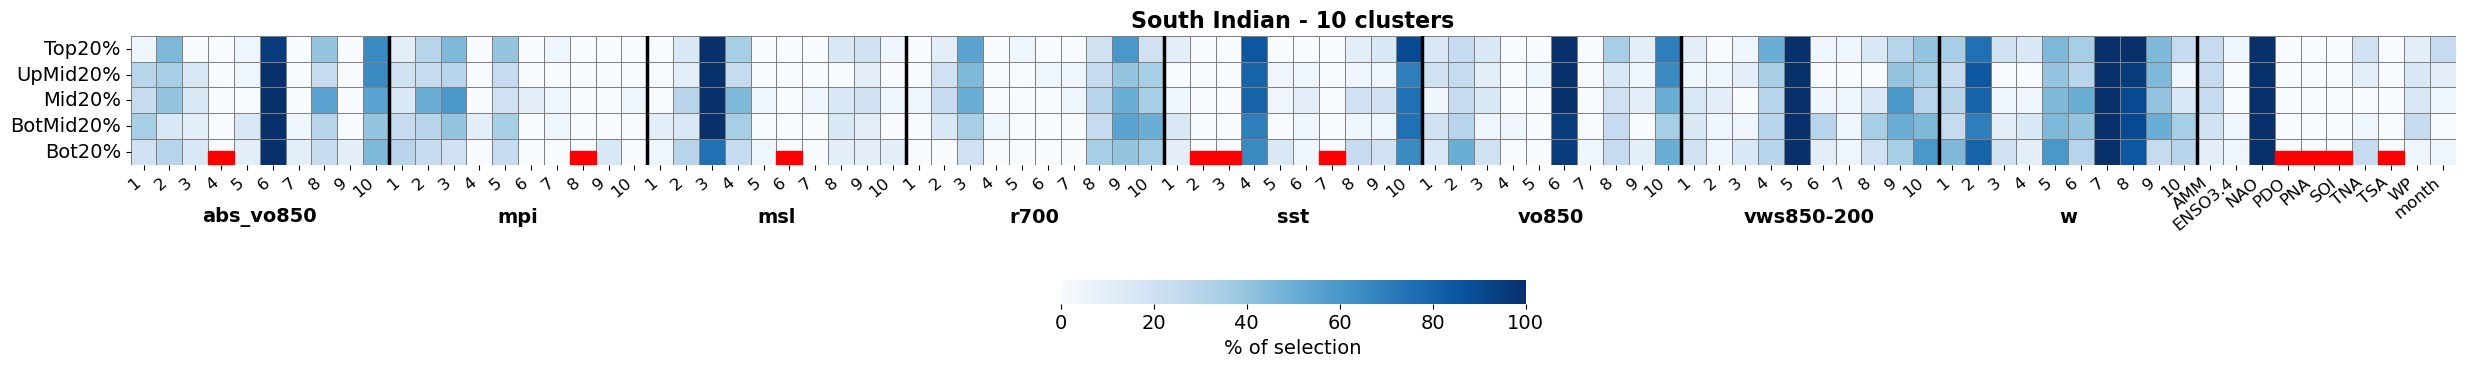

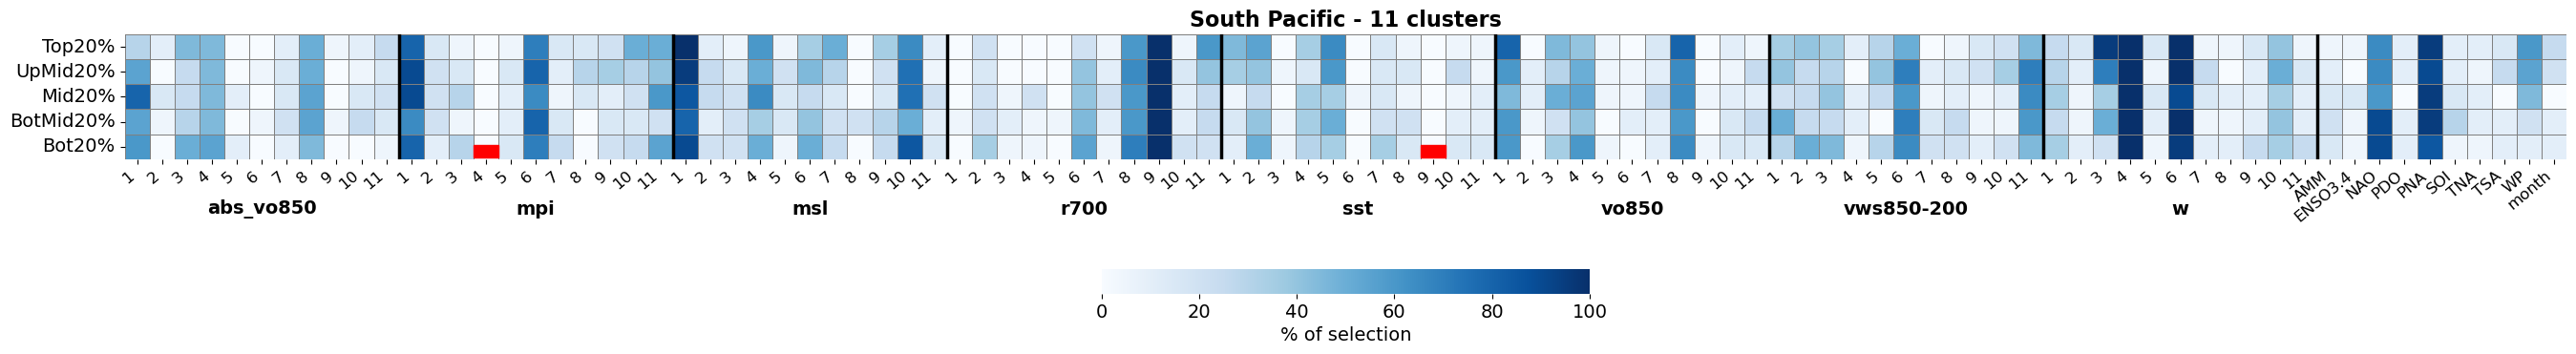

In [14]:
for bb, basin in enumerate(basins):
    # Set the number of clusters according ot the basin
    n_clusters = n_clusters_list[basins.index(basin)]
    # Get the predictors for the basin and the number of clusters
    cluster_data = f'{basin}_{n_clusters}clusters_noTS'
    experiment_filename = f'1980-2022_{n_clusters}clusters_8vars_9idxs.csv'
    predictor_file = 'predictors_' + experiment_filename
    predictors_path = os.path.join(fs_dir, 'data', cluster_data, predictor_file)
    predictors_df = pd.read_csv(predictors_path, index_col=0)
    predictors_df.index = pd.to_datetime(predictors_df.index)
    candidate_variables = predictors_df.columns.to_numpy()
    # Load the performance file for the basin and filter to get the simulation with the best performance
    track_file = os.path.join(results_dir, f'sim_performance_extra_{basin}_noTS.csv')
    track_df_extra = pd.read_csv(track_file, index_col=0)
    track_df_extra = track_df_extra[track_df_extra['model'] == 'linreg']
    track_df_extra = track_df_extra[track_df_extra['n_clusters'] == n_clusters]
    # Build the df containing the number of selection of each predictors
    sorted_df_extra = track_df_extra.sort_values(performance_col, ascending=True)
    df_tier_sel_perc_extra = pd.DataFrame(0, columns=candidate_variables, index=['Top20%', 'UpMid20%', 'Mid20%', 'BotMid20%', 'Bot20%'])
    n_sim = len(sorted_df_extra)
    for r, run_name in enumerate(sorted_df_extra.index):
        model_kind = run_name.split('_')[1]
        sol_filename = f'{model_kind}_{experiment_filename}'
        output_dir = os.path.join(fs_dir, 'results', basin, run_name)
        best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
        best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
        best_solution = best_solution.to_numpy().flatten()
        # Select the variables from the best solutions
        column_names = predictors_df.columns.tolist()
        feat_sel = best_solution[2*len(column_names):]
        if r < int(n_sim * 0.2):
            df_tier_sel_perc_extra.loc['Top20%'] = df_tier_sel_perc_extra.loc['Top20%'] + feat_sel
        elif r < int(n_sim * 0.4):
            df_tier_sel_perc_extra.loc['UpMid20%'] = df_tier_sel_perc_extra.loc['UpMid20%'] + feat_sel
        elif r < int(n_sim * 0.6):
            df_tier_sel_perc_extra.loc['Mid20%'] = df_tier_sel_perc_extra.loc['Mid20%'] + feat_sel
        elif r < int(n_sim * 0.8):
            df_tier_sel_perc_extra.loc['BotMid20%'] = df_tier_sel_perc_extra.loc['BotMid20%'] + feat_sel
        else:
            df_tier_sel_perc_extra.loc['Bot20%'] = df_tier_sel_perc_extra.loc['Bot20%'] + feat_sel
    df_tier_sel_perc_extra = (df_tier_sel_perc_extra / (n_sim * 0.2)) * 100
    plt.figure(figsize=(3*n_clusters, 10))
    ax = sns.heatmap(df_tier_sel_perc_extra, cmap="Blues", linewidths=0.5, linecolor="gray", square=True,
                    cbar_kws={'orientation': 'horizontal', 'label': '% of selection', 'shrink': 0.2, 'aspect': 20})
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('% of selection', fontsize=14)
    # Set xticks labels
    features_clustered = [var for var in candidate_variables if 'cluster' in var]
    features_non_clustered = [var for var in candidate_variables if 'cluster' not in var]
    cluster_numbers = [col.split("cluster")[-1] if "cluster" in col else "" for col in features_clustered]
    variables = [col.split("_cluster")[0] for col in features_clustered]
    variable_positions = [variables.index(var) for var in sorted(set(variables), key=variables.index)]
    xticks_labels = cluster_numbers + features_non_clustered
    ax.set_xticks(np.arange(len(candidate_variables)) + 0.5)  
    ax.set_xticklabels(xticks_labels, rotation=40, ha="right", fontsize=12)
    for i, var in enumerate(sorted(set(variables), key=variables.index)):
        xpos = variable_positions[i] + (variable_positions[i+1] - variable_positions[i]) / 2 if i < len(variable_positions) - 1 else variable_positions[i] + n_clusters/2
        ax.text(xpos, len(df_tier_sel_perc_extra) + 2, var, ha='center', va='center', fontsize=14, fontweight="bold")
    # Set the vertical lines between the different variables a bit thicker 
    thick_line_pos = [i+1 for i, var in enumerate(candidate_variables) if var.split('_cluster')[-1] == str(n_clusters)]
    for pos in thick_line_pos:
        ax.vlines(x=pos, ymin=-0.5, ymax=len(df_tier_sel_perc_extra), linewidth=2.5, color="black")
    # Overlay red blocks at the bottom for zero columns
    zero_columns = (df_tier_sel_perc_extra == 0).all(axis=0)
    for idx, is_zero in enumerate(zero_columns):
        if is_zero:
            ax.add_patch(plt.Rectangle((idx, len(df_tier_sel_perc_extra) - 0.55), 1, 0.5, color='red', clip_on=False))
    # Set the yticks labels fontsize
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    # Set the title
    plt.title(f'{basin_names[bb]} - {n_clusters} clusters', fontsize=16, fontweight="bold")
    plt.show()